In [1]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.hsv(np.linspace(0, 1, 256)) * 0.85, N=256
)
# colors = ["#95D3A2", "#FFFFBF", "#F79051", ]
colors = ["#5657A4", "#95D3A2", "#FFFFBF", "#F79051", "#A30644"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from main import *
from multiprocessing import Pool
import pandas as pd

SAVE_PATH = r"E:\MS_ExperimentData\general"

In [2]:
a = 1
b = -10
diffusionRateDv = 0.002
diffusionRateDu = 0.010

model = GSPatternFormation(strengthLambda=0, alpha=a, 
        boundaryLength=10, cellNumInLine=250, 
        productRateUK0=1, productRateVK0=1,
        decayRateKd=0.001, 
        chemoBetaU=b, chemoBetaV=b,
        diffusionRateDu=diffusionRateDu, diffusionRateDv=diffusionRateDv,
        dt=0.02, shotsnaps=5,
        tqdm=True, savePath=SAVE_PATH, overWrite=True)

# model.run(6000)

In [3]:
targetPath = f"{model.savePath}/{model}.h5"
totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="dotTheta")
totalU = pd.read_hdf(targetPath, key="u")
totalV = pd.read_hdf(targetPath, key="v")

TNum = totalPositionX.shape[0] // model.agentsNum
cellNumInLine = model.cellNumInLine

totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
totalU = totalU.values.reshape(TNum, cellNumInLine, cellNumInLine)
totalV = totalV.values.reshape(TNum, cellNumInLine, cellNumInLine)

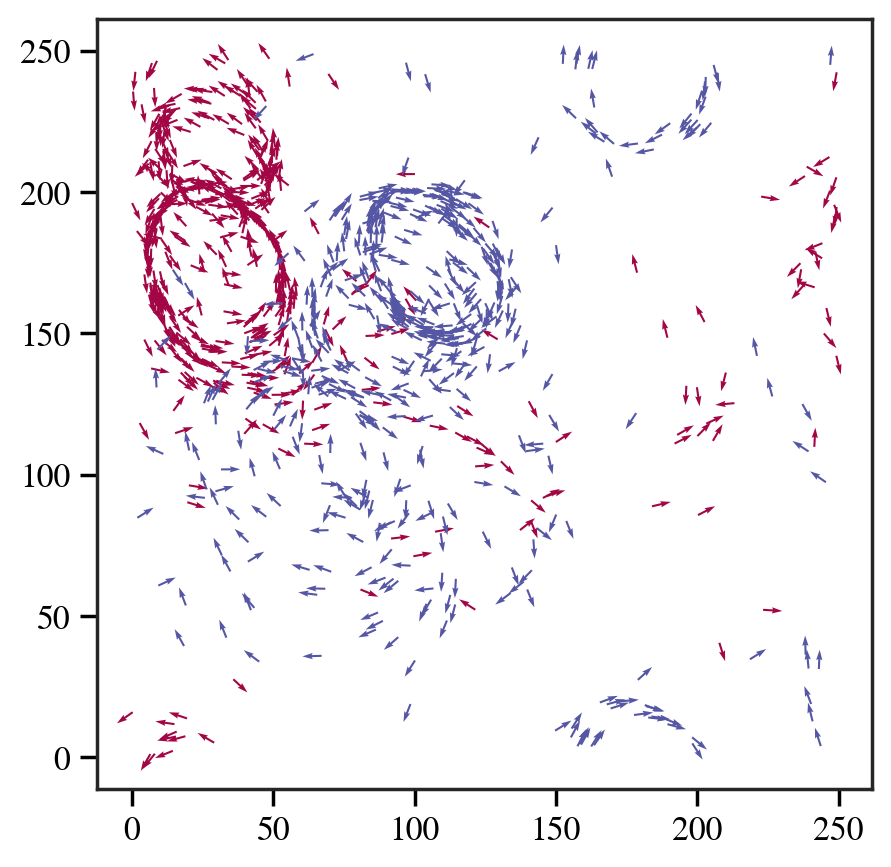

In [4]:
positionX = totalPositionX[-1]
phaseTheta = totalPhaseTheta[-1]
halfNum = model.agentsNum // 2
adjMulti = model.cellNumInLine / model.boundaryLength

plt.figure(figsize=(5, 5))
plt.quiver(
    positionX[:halfNum, 0] * adjMulti, positionX[:halfNum, 1] * adjMulti,
    np.cos(phaseTheta[:halfNum]), np.sin(phaseTheta[:halfNum]), color="#A30644", zorder=10
)
plt.quiver(
    positionX[halfNum:, 0] * adjMulti, positionX[halfNum:, 1] * adjMulti,
    np.cos(phaseTheta[halfNum:]), np.sin(phaseTheta[halfNum:]), color="#5657A4", zorder=10
)

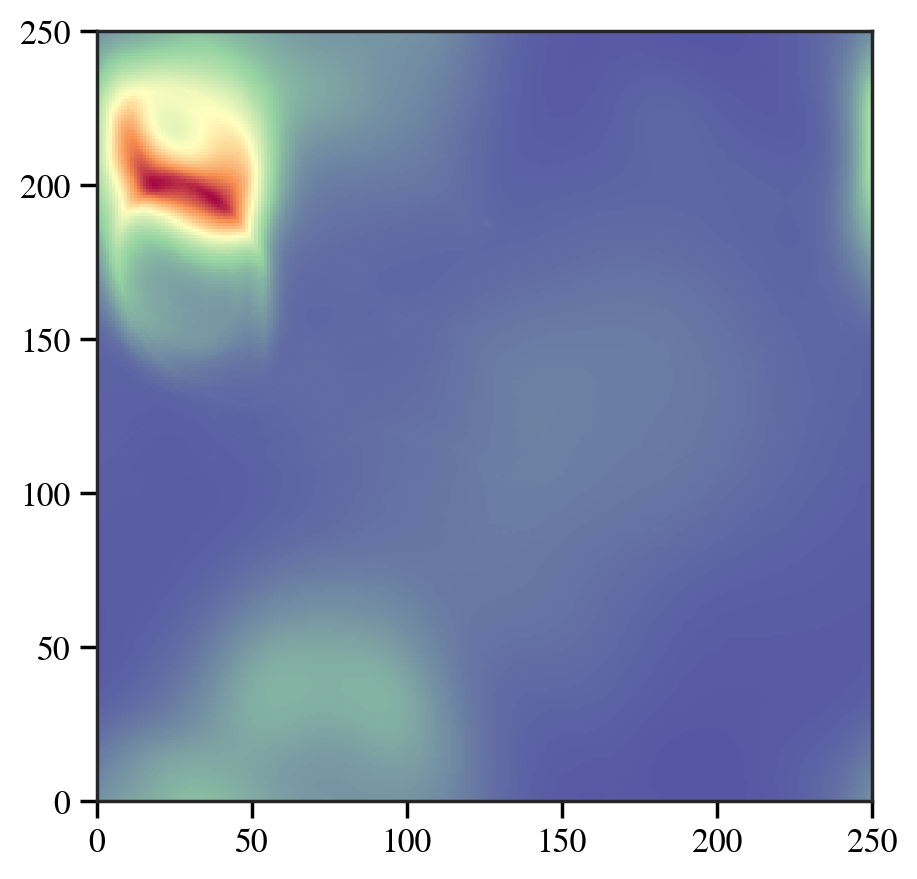

In [17]:
plt.figure(figsize=(5, 5))
plt.pcolor(totalU[-1].T, cmap=cmap)

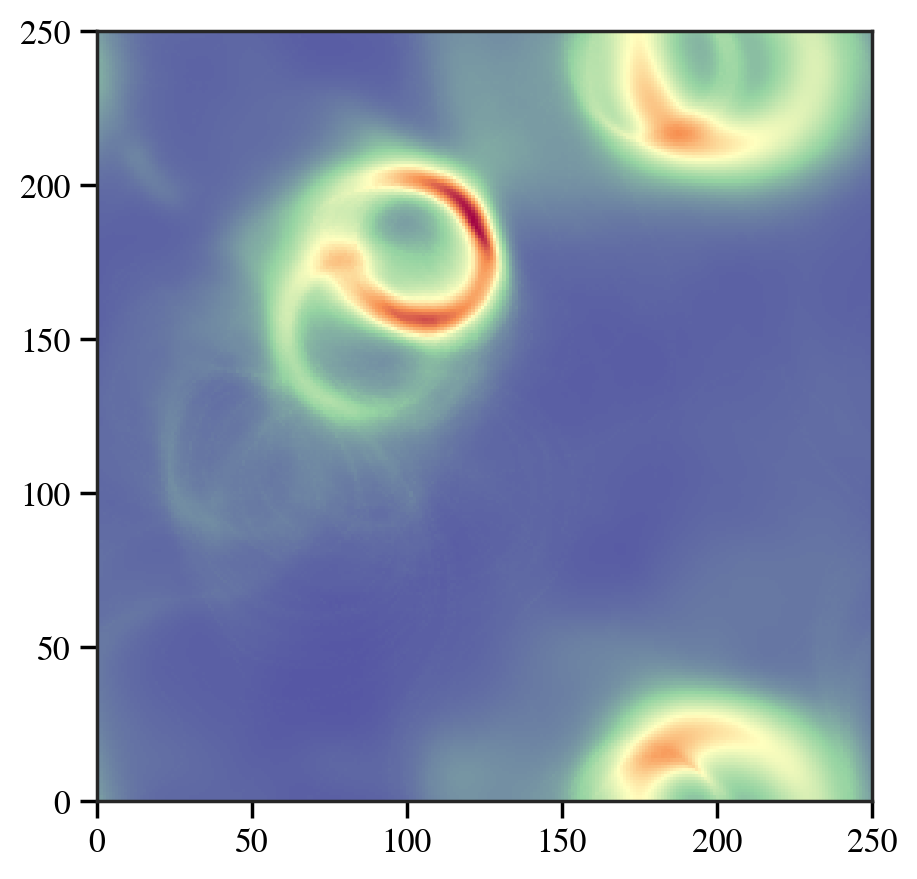

In [19]:
plt.figure(figsize=(5, 5))
plt.pcolor(totalV[-1].T, cmap=cmap)

In [33]:
boundaryLength = model.boundaryLength

xs = np.linspace(0, boundaryLength, cellNumInLine)
Xp, Yp = np.meshgrid(xs, xs)
Zp = totalU[-1].T
ZpV = totalV[-1].T

In [31]:
class1Pos = np.array([positionX[:halfNum, 0] * adjMulti, positionX[:halfNum, 1] * adjMulti, np.ones(halfNum) * Zp.max()]).T
class2Pos = np.array([positionX[halfNum:, 0] * adjMulti, positionX[halfNum:, 1] * adjMulti, np.ones(halfNum) * Zp.max()]).T

d:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


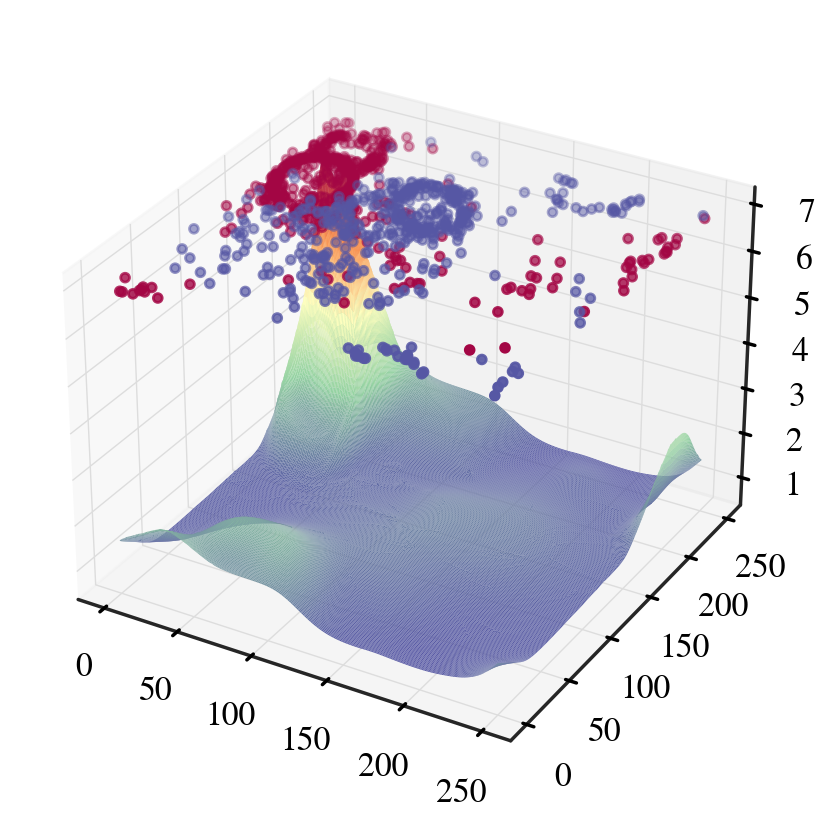

In [32]:
fig = plt.figure()
ax = fig.gca(projection="3d")

ax.plot_surface(Xp * adjMulti, Yp * adjMulti, Zp, cstride=1, rstride=1, edgecolor='none', cmap=cmap)
ax.scatter(*class1Pos.T, color="#A30644", s=10)
ax.scatter(*class2Pos.T, color="#5657A4", s=10)

d:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


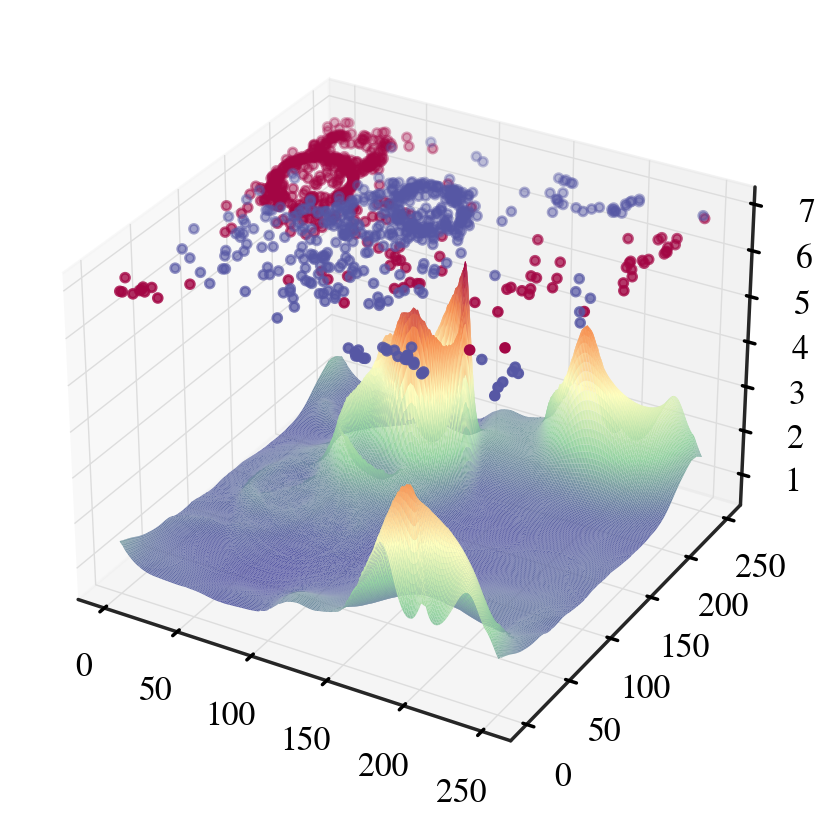

In [34]:
fig = plt.figure()
ax = fig.gca(projection="3d")

ax.plot_surface(Xp * adjMulti, Yp * adjMulti, ZpV, cstride=1, rstride=1, edgecolor='none', cmap=cmap)
ax.scatter(*class1Pos.T, color="#A30644", s=10)
ax.scatter(*class2Pos.T, color="#5657A4", s=10)

In [27]:
class1Pos.T

array([[ 39.03000942,  24.18823399,  42.14121816, ...,  35.18183739,
         35.27412556,  41.72677859],
       [185.39462988, 223.01322782, 148.29929658, ..., 138.23289703,
        204.47459909, 180.38845619],
       [  6.91913119,   6.91913119,   6.91913119, ...,   6.91913119,
          6.91913119,   6.91913119]])

d:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


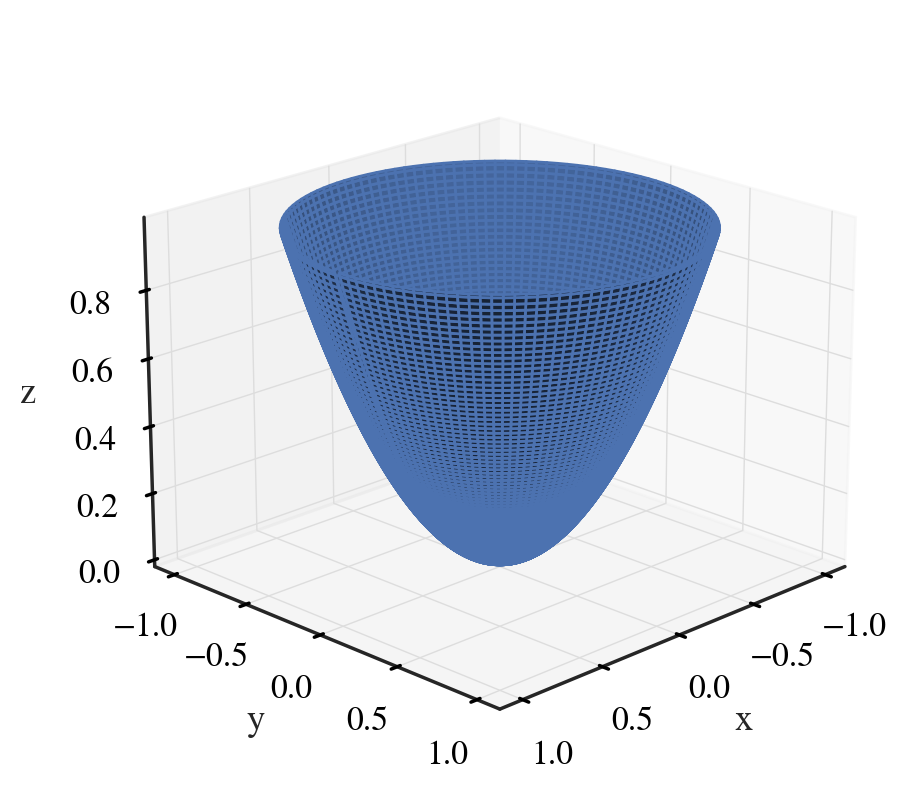

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import math

fig = plt.figure()             #建立图形窗口
ax = fig.gca(projection="3d")  #使用三维坐标
theta = np.arange( 0, 2 * math.pi, 0.05 )
rou  = np.arange( 0, 1, 0.005 )
T, R = np.meshgrid(theta, rou) #生成极角和极径的网格坐标
Xp = R * np.cos(T)   #根据极坐标计算横坐标
Yp = R * np.sin(T)    #根据极坐标计算纵坐标
Zp = Xp**2 + Yp**2  #把横坐标和纵坐标代入旋转抛物面函数得到竖坐标
ax.plot_surface(Xp, Yp, Zp, cstride=1, rstride=2, edgecolor='b')  #绘制旋转抛物面        
ax.set_xlabel( 'x' )
ax.set_ylabel( 'y' )
ax.set_zlabel( 'z' )
ax.view_init( 20, 45 )

In [8]:
Xp.shape

(200, 126)

In [9]:
Yp.shape

(200, 126)

In [10]:
Zp.shape

(200, 126)